In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
import wandb
from timm import create_model
from einops import rearrange, reduce
from sklearn.metrics import accuracy_score, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ColorJitter, Normalize, Compose, RandomAffine

In [3]:
torch.cuda.is_available()

True

## load datasets

In [4]:
class RegionImgTransform(object):
    def __init__(self, p=.8, brightness=.2, contrast=.2, saturation=.2, hue=.2,
                 normalize=True):
        
        self.affine_transforms = Compose([
            RandomAffine(180),
            RandomResizedCrop((256, 256), scale=(.6, 1.)),
        ])
        
        self.color_transforms = Compose([
            ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        ])
        
        if normalize:
#             self.normalize = Normalize((0.219, 0.223, 0.250), (0.223, 0.227, 0.251))
#             self.normalize = Normalize((0.138, 0.087, 0.143, 0.116, 0.261), (0.260, 0.227, 0.239, 0.230, 0.276))
            self.normalize = Normalize((0.2126, 0.2129, 0.2696), (0.2147, 0.2118, 0.2238))
        else:
            self.normalize = nn.Identity()
 
        self.p = p
    
    def __call__(self, he, mask):
        """
        """
        if torch.rand(size=(1,)) < self.p:
            he = self.color_transforms(he)
            
            combined = torch.concat((he, mask))
            combined = self.affine_transforms(combined)
            
            he, mask = combined[:-1], combined[-1:]
            
        he = self.normalize(he)
        
        return he, mask

In [5]:
class RegionDataset(Dataset):
    def __init__(self, region_to_cls_imgs, transform=None):
        self.region_to_cls_imgs = region_to_cls_imgs
        self.transform = transform
        self.keys = sorted(self.region_to_cls_imgs.keys())
        
        self.labels = sorted(set([d['label'] for reg, d in region_to_cls_imgs.items()]))
        self.y = [self.labels.index(self.region_to_cls_imgs[k]['label']) for k in self.keys]
        self.y = torch.nn.functional.one_hot(torch.tensor(
            self.y)).to(torch.float32)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        region_id = self.keys[idx]

        rgb = self.region_to_cls_imgs[region_id]['rgb']
        mask = self.region_to_cls_imgs[region_id]['mask']
        mask = mask.to(torch.float32)

        if self.transform:
            rgb, mask = self.transform(rgb, mask)

        return {
            'mask': mask,
            'rgb': rgb,
            'y': self.y[idx],
        }

In [6]:
# !pip install tornado==6.2

In [7]:
train_ds = torch.load('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/datasets/train.pt')
val_ds = torch.load('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/datasets/val.pt')
pred_ds = torch.load('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/datasets/prediction.pt')

In [8]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=10)
pred_dl = DataLoader(pred_ds, batch_size=batch_size, num_workers=10)

In [9]:
d = train_ds[0]
d.keys()

dict_keys(['mask', 'rgb', 'y'])

In [10]:
d['rgb'].dtype, d['mask'].dtype, d['y'].shape

(torch.float32, torch.float32, torch.Size([4]))

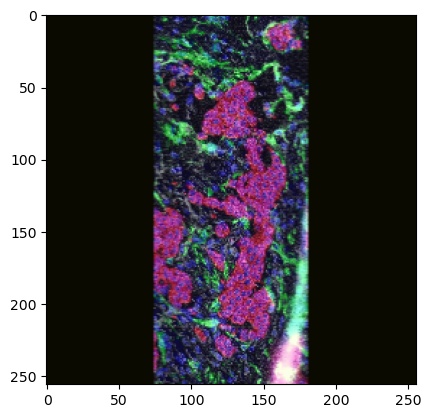

In [11]:
img = rearrange(d['rgb'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

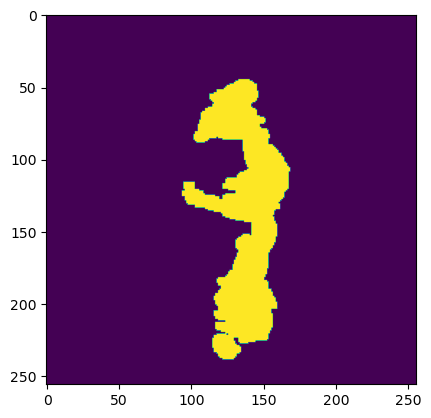

In [12]:
plt.imshow(d['mask'][0])

In [13]:
d['y']

tensor([0., 0., 1., 0.])

In [14]:
b = next(iter(train_dl))
b.keys()

dict_keys(['mask', 'rgb', 'y'])

In [15]:
b['rgb'].dtype, b['mask'].dtype

(torch.float32, torch.float32)

## model

In [16]:
class RegionClassifier(nn.Module):
    def __init__(
            self,
            n_classes,
            n_features=100,
            n_channels=3,
            backbone='resnet34',
    ):
        super().__init__()
        self.rgb_encoder = create_model(backbone, in_chans=n_channels)
        self.mask_encoder = create_model(backbone, in_chans=1)
        
        self.encoded_downsample = nn.Linear(1000, n_features)
        
        self.head = nn.Sequential(
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(n_features, n_classes),
            nn.Softmax(dim=-1)
        )
        
        self.loss = nn.CrossEntropyLoss()   
        
    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

    def forward(self, rgb, mask):
        rgb_encoded = self.rgb_encoder(rgb)
        mask_encoded = self.mask_encoder(mask)
        encoded = rgb_encoded + mask_encoded
        encoded = self.encoded_downsample(encoded)

        probs = self.head(encoded)
        
        return probs


In [17]:
n_classes, n_channels = b['y'].shape[1], b['rgb'].shape[1]

model = RegionClassifier(n_classes, n_channels=n_channels)
out = model(b['rgb'], b['mask'])
out.shape

torch.Size([32, 4])

In [18]:
model.calculate_loss(out, b['y'])

tensor(1.3759, grad_fn=<DivBackward1>)

In [19]:
class ModelLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        
        self.model = model
        self.lr = lr
        
#         self.save_hyperparameters(ignore=['model'])
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        rgb, mask, y = batch['rgb'], batch['mask'], batch['y']
        probs = self.model(rgb, mask)
        loss = self.model.calculate_loss(probs, y)
        acc = accuracy_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                             probs.argmax(dim=-1).clone().detach().cpu().numpy())
        f1 = f1_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                      probs.argmax(dim=-1).clone().detach().cpu().numpy(), average='weighted')
        
        self.log_dict({'train/loss': loss, 'train/acc': acc, 'train/f1': f1},
                      on_step=False, on_epoch=True, prog_bar=True)
        
        
        result = {'loss': loss, 'probs': probs, 'y': y}
        return result
    
    def validation_step(self, batch, batch_idx):
        rgb, mask, y = batch['rgb'], batch['mask'], batch['y']
        probs = self.model(rgb, mask)
        loss = self.model.calculate_loss(probs, y)
        acc = accuracy_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                             probs.argmax(dim=-1).clone().detach().cpu().numpy())
        f1 = f1_score(y.argmax(dim=-1).clone().detach().cpu().numpy(),
                      probs.argmax(dim=-1).clone().detach().cpu().numpy(), average='weighted')
        
        self.log_dict({'val/loss': loss, 'val/acc': acc, 'val/f1': f1},
                      on_step=False, on_epoch=True, prog_bar=True)
        
        
        result = {'loss': loss, 'probs': probs, 'y': y}
        return result
    
    def prediction_step(self, batch, batch_idx):
        rgb, mask, y = batch['rgb'], batch['mask'], batch['y']
        probs = self.model(rgb, mask)

        result = {'y_pred': probs.argmax(dim=-1), 'probs': probs, 'y_true': y}
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, batch):
        rgb, mask, y = batch['rgb'], batch['mask'], batch['y']
        return self.model(rgb, mask)

In [20]:
class LoggingCallback(pl.Callback):
    def __init__(self, log_every=10, log_n_samples=8):
        self.log_every = log_every
        self.log_n_samples = log_n_samples
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if trainer.current_epoch % self.log_every == 0 and batch_idx==0:
            img = batch['rgb'][:self.log_n_samples].clone().detach().cpu()
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"train/rgb",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[train_ds.labels[i]
                         for i in outputs['probs'][:self.log_n_samples].argmax(dim=-1).clone().detach().cpu().numpy()]
            )
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        if trainer.current_epoch % self.log_every == 0 and batch_idx==0:
            img = batch['rgb'][:self.log_n_samples].clone().detach().cpu()
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"val/rgb",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[train_ds.labels[i]
                         for i in outputs['probs'][:self.log_n_samples].argmax(dim=-1).clone().detach().cpu().numpy()]
            )


## training model

In [21]:
project = 'region_classifier'
log_dir = '/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/logs'
Path(log_dir).mkdir(parents=True, exist_ok=True)

In [22]:
from pytorch_lightning.loggers import WandbLogger
logger = WandbLogger(project=project, save_dir=log_dir)

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


In [23]:
# wandb.finish()

In [24]:
config = {
    'n_classes': train_ds.y.shape[1],
    'n_features': 100,
    'backbone': 'resnet34',
    'n_channels': train_ds[0]['rgb'].shape[0],
    'training': {
        'train_samples': len(train_ds),
        'val_samples': len(val_ds),
        'log_n_samples': 16,
        'max_epochs': 500,
        'check_val_every_n_epoch': 1,
        'log_every': 1,
        'accelerator': 'gpu',
#         'devices': 1,
        'devices': [1],
        'lr': 2e-4,
        'batch_size': batch_size,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [25]:
m = RegionClassifier(
    config['n_classes'],
    n_channels=config['n_channels'],
    backbone=config['backbone']
)
model = ModelLightning(m, lr=config['training']['lr'])

/data/estorrs/miniconda3/envs/generic_pytorch/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [26]:
# !mkdir /data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/ckpts

In [27]:
trainer = pl.Trainer(
    callbacks=[
        LoggingCallback(
            log_every=config['training']['log_every'],
            log_n_samples=config['training']['log_n_samples']
        ),
        ModelCheckpoint(
            dirpath="/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/ckpts",
            save_top_k=5, monitor="val/loss"
        )
    ],
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    check_val_every_n_epoch=config['training']['check_val_every_n_epoch'],
    enable_checkpointing=True,
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

/data/estorrs/miniconda3/envs/generic_pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type             | Params
-------------------------------------------
0 | model | RegionClassifier | 43.7 M
-------------------------------------------
43.7 M    Trainable params
0         Non-trainable params
43.7 M    Total params
174.841   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/data/estorrs/miniconda3/envs/generic_pytorch/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
cb = [c for c in trainer.callbacks if 'ModelCheckpoint' in str(type(c))][0]
cb.best_model_path

'/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/ckpts/epoch=447-step=7168.ckpt'

In [30]:
best = ModelLightning.load_from_checkpoint(cb.best_model_path)

/data/estorrs/miniconda3/envs/generic_pytorch/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [31]:
result = trainer.predict(best, dataloaders=pred_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

In [32]:
probs = result[0]
for x in result[1:]:
    probs = torch.concat((probs, x), dim=0)
probs.shape

torch.Size([9950, 4])

In [33]:
df = pd.DataFrame(data=probs.detach().cpu().numpy(), columns=train_ds.labels, index=pred_ds.keys)
df.index.name = 'region_id'
df

,artifact,dcis,idc,normal
region_id,,,,
HT110B1_S1H4_1,2.474620e-05,9.998623e-01,0.000075,3.838993e-05
HT110B1_S1H4_10,1.403064e-06,9.023645e-06,0.999989,6.770355e-07
HT110B1_S1H4_100,3.269456e-06,3.352918e-05,0.999957,5.890300e-06
HT110B1_S1H4_101,2.608848e-07,1.441338e-07,1.000000,3.697922e-08
HT110B1_S1H4_102,1.719461e-06,5.704798e-06,0.999991,1.609826e-06
...,...,...,...,...
HT565B1-H2_04262023_89,9.198514e-04,1.501836e-01,0.005554,8.433428e-01
HT565B1-H2_04262023_9,8.197178e-06,9.661377e-05,0.999893,2.155998e-06
HT565B1-H2_04262023_90,3.312618e-05,1.948579e-04,0.000107,9.996650e-01


In [36]:
df.to_csv('/data/estorrs/multiplex_data/analysis/dcis_region_analysis/classifier_v3/results/probs.txt', sep='\t')